По базе машин с ЮЛЫ данным обучите модель для предсказания цен на машины.

1. Создайте обучающую, тестовую и проверочную выборки.

2. Оцените качество работы созданной сети, определив средний процент ошибки на проверочной выборке. (Для этого потребуется привести предсказанные моделью значения к первоначальному диапазону цен.)  

3. Подсчитайте ошибку на каждом примере тестовой выборки и суммарный процент ошибки.


Рекомендации:
- в качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).
- метрику для данной задачи можно не использовать.
- последний слой модели должен иметь 1 нейрон.
- суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины. Например, если средняя цена машины 560.000 р, а средняя ошибка 56.000р, то процент ошибки равен 10%.


In [1]:
# Загрузка датафрейма из google облака
import gdown

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/cars_new.csv', None, quiet=True)

'cars_new.csv'

In [2]:
# Ваше решение
from tensorflow.keras.callbacks import LambdaCallback

# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    SpatialDropout1D,
    BatchNormalization,
    Embedding,
    Flatten,
    Activation,
    Input,
    Concatenate,
)
from tensorflow.keras.layers import (
    SimpleRNN,
    GRU,
    LSTM,
    Bidirectional,
    Conv1D,
    MaxPooling1D,
    GlobalMaxPooling1D,
)

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

E0000 00:00:1747005128.101502  145150 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747005128.111827  145150 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv(
    "cars_new.csv", encoding="utf-8", sep=",", header=0,
)  # Загружаем базу
df.head()


,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [4]:
df.fillna("Неизвестно", inplace=True)

In [5]:
COL_MARK = df.columns.get_loc("mark")
COL_MODEL = df.columns.get_loc("model")
COL_PRICE = df.columns.get_loc("price")
COL_YEAR = df.columns.get_loc("year")
COL_MILEAGE = df.columns.get_loc("mileage")
COL_BODY = df.columns.get_loc("body")
COL_KPP = df.columns.get_loc("kpp")
COL_FUEL = df.columns.get_loc("fuel")
COL_VOLUME = df.columns.get_loc("volume")
COL_POWER = df.columns.get_loc("power")


In [6]:
def num_to_scale(column, save_scaler=False):
    scaler = StandardScaler()
    column_reshaped = column.values.reshape(-1, 1)
    normalized = scaler.fit_transform(column_reshaped)
    if save_scaler:
        return normalized, scaler
    else:
        return normalized

In [7]:
def text_to_ohe(column):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    col_ohe = ohe.fit_transform(column.values.reshape(-1, 1))
    return col_ohe


In [8]:
def text_to_seq(column, max_len=10):
    tokenizer = Tokenizer(
        num_words=10000,  # объем словаря
        filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0',  # убираемые из текста ненужные символы
        lower=True,  # приведение слов к нижнему регистру
        split=" ",  # разделитель слов
        oov_token="unknown",  # указание разделять по словам, а не по единичным символам
        char_level=False,  # токен для слов, которые не вошли в словарь
    )
    tokenizer.fit_on_texts(column)
    sequences = tokenizer.texts_to_sequences(column)
    padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
    return padded

In [9]:
def construct_train_data(df: pd.DataFrame):
    mark_ohe = text_to_ohe(df.iloc[:, COL_MARK])
    model_seq = text_to_seq(df.iloc[:, COL_MODEL])
    price_col, y_scaler = num_to_scale(df.iloc[:, COL_PRICE], save_scaler=True)
    year_col = num_to_scale(df.iloc[:, COL_YEAR])
    mileage_col = num_to_scale(df.iloc[:, COL_MILEAGE])
    body_ohe = text_to_ohe(df.iloc[:, COL_BODY])
    kpp_ohe = text_to_ohe(df.iloc[:, COL_KPP])
    fuel_ohe = text_to_ohe(df.iloc[:, COL_FUEL])
    volume_col = num_to_scale(df.iloc[:, COL_VOLUME])
    power_col = num_to_scale(df.iloc[:, COL_POWER])

    x_data = np.hstack(
        [
            year_col,
            mileage_col,
            volume_col,
            power_col,
            mark_ohe,
            body_ohe,
            kpp_ohe,
            fuel_ohe,
        ]
    )

    return x_data, model_seq, price_col, y_scaler, df.iloc[:, COL_PRICE]

In [10]:
print(df.iloc[:, COL_MARK].values.reshape(-1, 1))

[['kia']
 ['daewoo']
 ['suzuki']
 ...
 ['mazda']
 ['toyota']
 ['chevrolet']]


In [21]:
x_data, x_seq, y_data, y_scaler, y_true = construct_train_data(df)

(x_train, x_test, x_seq_train, x_seq_test, y_train, y_test, _, y_true_test) = (
    train_test_split(
        x_data, x_seq, y_data, y_true, test_size=0.15, random_state=42
    )
)

In [12]:
input_numeric = Input(shape=(x_train.shape[1],), name="numeric_input")
x_numeric = Dense(512, activation="relu")(input_numeric)
x_numeric = Dropout(0.2)(x_numeric)
x_numeric = Dense(256, activation="relu")(x_numeric)

input_seq = Input(shape=(x_seq_train.shape[1],), name="seq_input")
x_seq = Embedding(input_dim=10000, output_dim=64, mask_zero=True)(input_seq)
x_seq = LSTM(32, return_sequences=True)(x_seq)
x_seq = LSTM(32)(x_seq)

x = Concatenate()([x_numeric, x_seq])
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="linear")(x)

model = Model(inputs=[input_numeric, input_seq], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse", metrics=["mae"])

I0000 00:00:1747005134.047822  145150 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [18]:
def check_mae_double_input(
    model, x_data, x_data_text, y_data_not_scaled, scaler, plot=False
):
    y_pred_scaled = model.predict([x_data, x_data_text])
    y_pred_not_scaled = scaler.inverse_transform(y_pred_scaled)

    mae = mean_absolute_error(y_data_not_scaled, y_pred_not_scaled)
    print(
        "Среднаяя абслолютная ошибка {:.3f} рублей это {:.3f}% от общей выборки в {} примеров.".format(
            mae, (mae / y_data_not_scaled.mean(axis=0)) * 100, len(x_data)
        )
    )

    if plot:
        plt.scatter(y_data_not_scaled, y_pred_not_scaled, alpha=0.3)
        plt.xlabel("Правильные значения")
        plt.ylabel("Предсказания")
        plt.plot([0, 2e7], [0, 2e7], color="red", linestyle="--", label="Идеал (y = x)")
        plt.gca().set_aspect("equal", adjustable="box")
        plt.show()


def make_callback(model, x_data, x_seq, y_true, y_scaler, plot=True):
    def on_epoch_end(epoch, logs=None):
        print(f"\nЭпоха {epoch + 1}:")
        if epoch == 0 or (epoch + 1) % 5 == 0:
            check_mae_double_input(model, x_data, x_seq, y_true, y_scaler, plot=plot)

    return LambdaCallback(on_epoch_end=on_epoch_end)


pltMae = make_callback(model, x_test, x_seq_test, y_true_test, y_scaler)


I0000 00:00:1747005138.689736  145281 cuda_dnn.cc:529] Loaded cuDNN version 90300



Эпоха 1:
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Среднаяя абслолютная ошибка 100149.719 рублей это 19.140% от общей выборки в 10518 примеров.


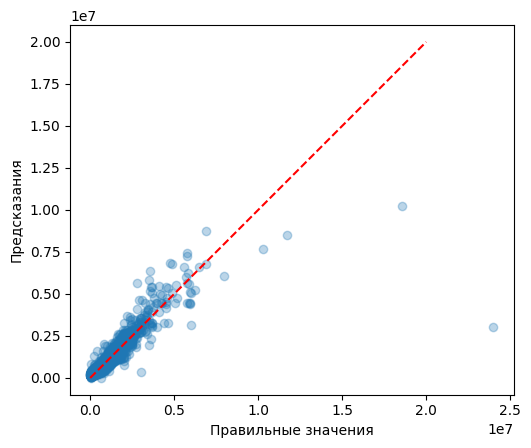


Эпоха 2:

Эпоха 3:

Эпоха 4:

Эпоха 5:
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Среднаяя абслолютная ошибка 87479.445 рублей это 16.719% от общей выборки в 10518 примеров.


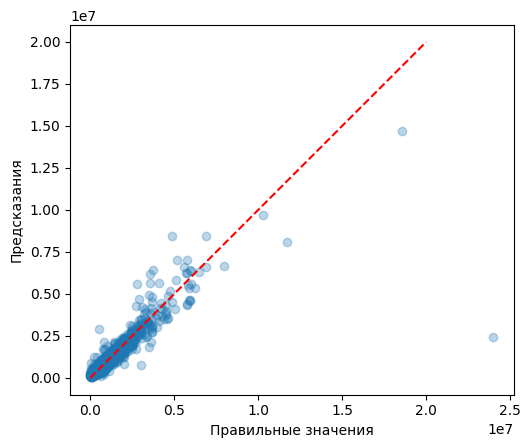


Эпоха 6:

Эпоха 7:

Эпоха 8:

Эпоха 9:

Эпоха 10:
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Среднаяя абслолютная ошибка 90283.312 рублей это 17.254% от общей выборки в 10518 примеров.


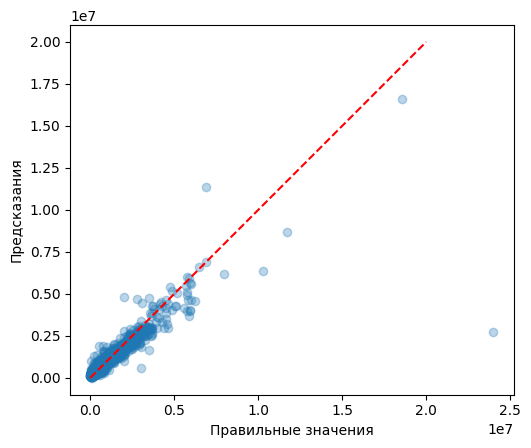


Эпоха 11:

Эпоха 12:

Эпоха 13:

Эпоха 14:

Эпоха 15:
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Среднаяя абслолютная ошибка 87094.219 рублей это 16.645% от общей выборки в 10518 примеров.


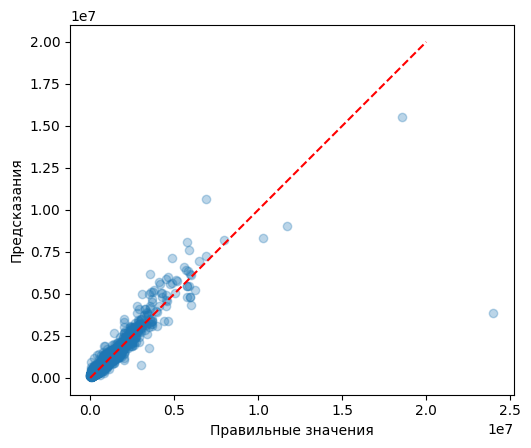


Эпоха 16:

Эпоха 17:

Эпоха 18:

Эпоха 19:

Эпоха 20:
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Среднаяя абслолютная ошибка 85969.977 рублей это 16.430% от общей выборки в 10518 примеров.


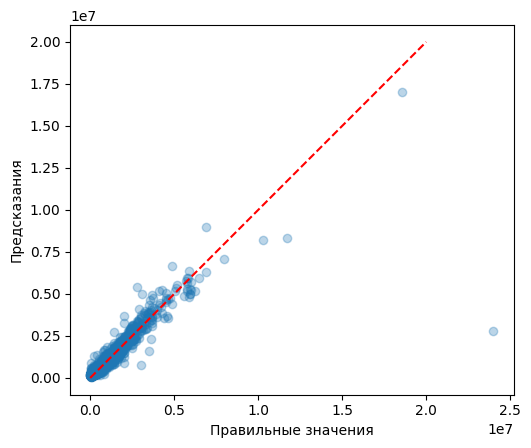


Эпоха 21:

Эпоха 22:

Эпоха 23:

Эпоха 24:

Эпоха 25:
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Среднаяя абслолютная ошибка 94612.844 рублей это 18.082% от общей выборки в 10518 примеров.


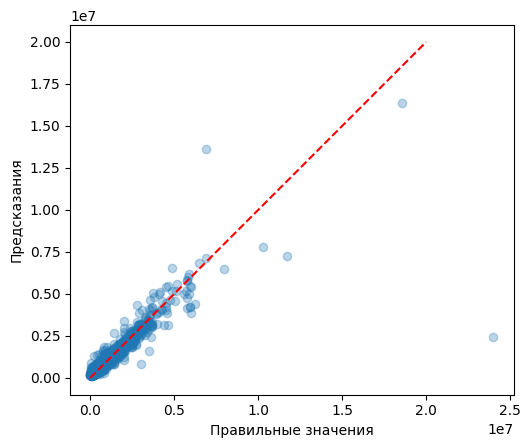


Эпоха 26:

Эпоха 27:

Эпоха 28:

Эпоха 29:

Эпоха 30:
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Среднаяя абслолютная ошибка 86748.711 рублей это 16.579% от общей выборки в 10518 примеров.


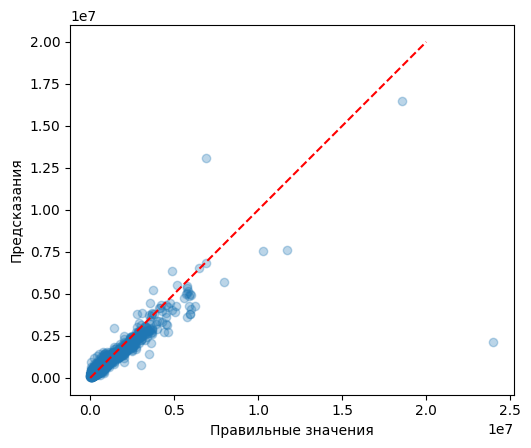


Эпоха 31:

Эпоха 32:

Эпоха 33:

Эпоха 34:

Эпоха 35:
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Среднаяя абслолютная ошибка 91321.102 рублей это 17.453% от общей выборки в 10518 примеров.


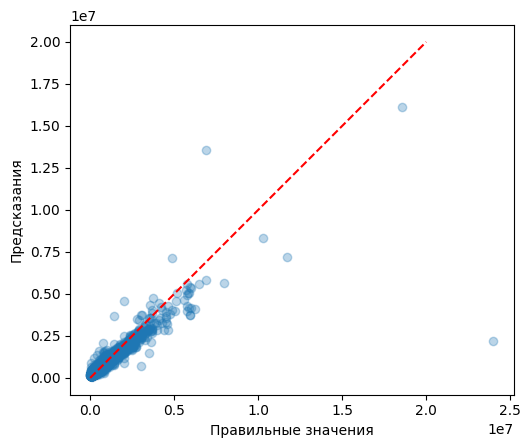


Эпоха 36:

Эпоха 37:

Эпоха 38:

Эпоха 39:

Эпоха 40:
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Среднаяя абслолютная ошибка 79197.352 рублей это 15.136% от общей выборки в 10518 примеров.


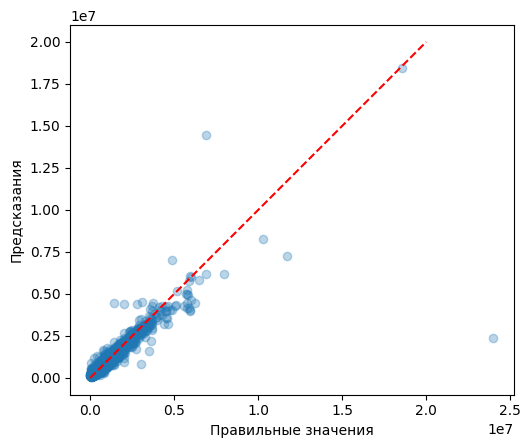


Эпоха 41:

Эпоха 42:

Эпоха 43:

Эпоха 44:

Эпоха 45:
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Среднаяя абслолютная ошибка 82194.031 рублей это 15.709% от общей выборки в 10518 примеров.


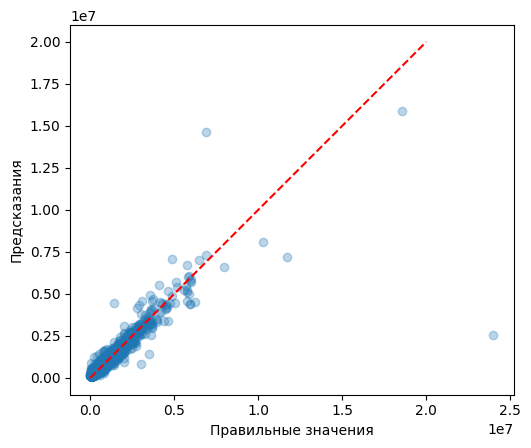


Эпоха 46:

Эпоха 47:

Эпоха 48:

Эпоха 49:

Эпоха 50:
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Среднаяя абслолютная ошибка 84387.266 рублей это 16.128% от общей выборки в 10518 примеров.


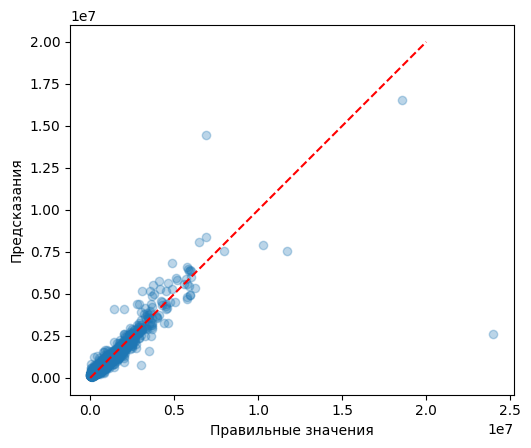

In [14]:
history = model.fit(
    [x_train, x_seq_train],
    y_train,
    validation_split=0.15,
    epochs=50,
    batch_size=256,
    callbacks=[pltMae],
    verbose=0,
)


In [15]:
def plot_history(history):
    plt.plot(
        history.history["mae"], label="Средняя абсолютная ошибка на обучающем наборе"
    )
    plt.plot(
        history.history["val_mae"],
        label="Средняя абсолютная ошибка на проверочном наборе",
    )
    plt.xlabel("Эпоха обучения")
    plt.ylabel("Средняя абсолютная ошибка")
    plt.legend()
    plt.show()


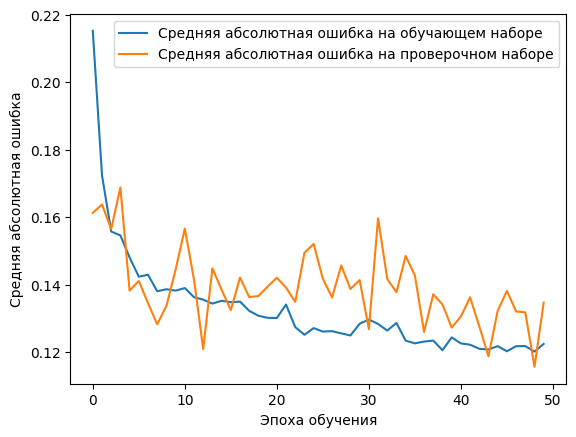

In [16]:
plot_history(history)

2192/2192 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
Среднаяя абслолютная ошибка 78227.953 рублей это 14.824% от общей выборки в 70119 примеров.


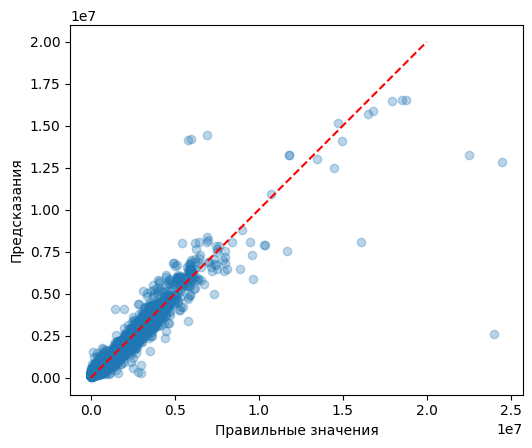

In [22]:
check_mae_double_input(model, x_data, x_seq, y_true, y_scaler, plot=True)